In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cell 1: ติดตั้ง libraries ที่จำเป็น
!pip install unsloth transformers datasets sentence-transformers
!pip install langchain langchain-community faiss-cpu chromadb
!pip install pandas numpy torch accelerate bitsandbytes
!pip install scikit-learn matplotlib seaborn
!pip install rouge-score bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 11.0 MB/s eta 0:00

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=da17299ee5c09367ea10491ec8c5b97e207af565d5bdb7b7b234a704b3b4f420
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [1]:
# Cell 1: Setup and Dependencies
import os
import gc
import torch
import pandas as pd
import random
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from unsloth import FastLanguageModel
from trl import SFTTrainer

# Memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.empty_cache()
gc.collect()

# Configuration
MODEL_NAME = "scb10x/llama3.2-typhoon2-t1-3b-research-preview"
DATA_PATH = "/content/drive/MyDrive/AlphaZero_Backups/data/36_stratagems.csv"
OUTPUT_DIR = "/content/drive/MyDrive/AlphaZero_Backups/model"
EPOCHS = 10  # ลดลงเพื่อประหยัดเวลา
BATCH_SIZE = 1  # ลดลงเพื่อใช้ memory น้อยลง
LR = 2e-5  # ลดลงอีก
MAX_SEQ_LENGTH = 512  # ลดลงเพื่อประหยัด memory
VAL_SPLIT = 0.15

WARMUP_STEPS = 50
EVAL_SAVE_STEPS = 50

print("Setup completed")
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

/tmp/ipython-input-1-4175964496.py:14: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Setup completed
GPU Available: True
GPU Memory: 15.8 GB


In [15]:
# --- Cell 2: Data Analysis และการสร้าง Prompt ---
df = pd.read_csv(DATA_PATH, encoding='utf-8')
print("\n--- Data Analysis ---")
print(f"Total records: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"Unique strategies: {df['ชื่อกลยุทธ์'].nunique()}")
print("\nCategory distribution:")
print(df['หมวด'].value_counts())

# แสดงตัวอย่างข้อมูล
print("\n--- Sample Data from CSV ---")
for i in range(min(2, len(df))):
    print(f"\nRecord {i+1}:")
    print(f"  Strategy: {df.iloc[i]['ชื่อกลยุทธ์']}")
    print(f"  Category: {df.iloc[i]['หมวด']}")
    print(f"  Scenario: {df.iloc[i]['สถานการณ์'][:100]}...")

def create_advanced_stratagem_prompt(record):
    """
    สร้าง prompt ที่มีโครงสร้างการคิด (Chain of Thought) ตามระเบียบวิธีวิจัย
    และมีคำตอบที่ดึงมาจากข้อมูลใน DataFrame เพื่อใช้เป็นตัวอย่างการฝึก (Training Example)
    """

    # สร้าง situation vector อย่างง่าย (mock data) เพื่อจำลองการวิเคราะห์
    # ในโลกจริง ค่าเหล่านี้ควรมาจากการวิเคราะห์สถานการณ์จริงๆ
    situation_vector = {
        'p1': round(random.uniform(1.0, 5.0), 2),
        'p2': round(random.uniform(1.0, 5.0), 2),
        'p3': round(random.uniform(1.0, 5.0), 2),
        'p4': round(random.uniform(1.0, 5.0), 2),
        'p5': round(random.uniform(1.0, 5.0), 2),
        'p6': round(random.uniform(1.0, 5.0), 2)
    }

    situation_vector_str = ", ".join([f"'{k}': {v}" for k, v in situation_vector.items()])

    # จำลองคะแนนความสอดคล้อง
    alignment_score = round(random.uniform(0.75, 0.95), 2)

    # จำลองการหาค่าพารามิเตอร์ที่สอดคล้องหลัก (Key Alignment)
    # โดยการหาค่า p ที่มีค่าสูงสุด 2-3 อันดับแรกจาก vector ที่สุ่มขึ้นมา
    top_params = sorted(situation_vector, key=situation_vector.get, reverse=True)[:random.randint(2, 3)]
    key_alignment_params = ", ".join(top_params)

    return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>คุณคือ AI assistant ที่เชี่ยวชาญในการวิเคราะห์สถานการณ์และการแนะนำกลยุทธ์ที่เหมาะสม คุณใช้กรอบการวิเคราะห์ 6C Model เพื่อประเมินสถานการณ์ และเชื่อมโยงกับกลยุทธ์ 36 กลยุทธ์ ผ่านการวิเคราะห์เชิงความหมาย

คุณต้องปฏิบัติตามขั้นตอนการเลือกกลยุทธ์อย่างเป็นระบบ โดยการวิเคราะห์บริบทสถานการณ์ กำหนดค่าพารามิเตอร์ที่สำคัญ และคำนวณคะแนนความสอดคล้องเพื่อแนะนำกลยุทธ์ที่เหมาะสมที่สุด

สถานการณ์: {record['สถานการณ์']}

คำถาม: จากสถานการณ์ที่กำหนด จงวิเคราะห์และแนะนำกลยุทธ์ที่เหมาะสมที่สุดตามระเบียบวิธีการวิเคราะห์ที่เป็นระบบ<|eot_id|><|start_header_id|>assistant<|end_header_id|><thoughts>
<plan>
<step order="1">วิเคราะห์บริบทสถานการณ์และกำหนด Situation Vector (x)</step>
<step order="2">เรียกใช้ Invariant Distribution (d_j) ของแต่ละกลยุทธ์จากฐานข้อมูล</step>
<step order="3">คำนวณคะแนนความสอดคล้อง (score_j) โดยเปรียบเทียบ Situation Vector (x) กับ Invariant Distribution (d_j) ของแต่ละกลยุทธ์</step>
<step order="4">จัดอันดับกลยุทธ์ (Ranked list) และกรองผลลัพธ์ด้วยค่า Threshold (θ)</step>
<step order="5">สร้างรายงานสรุปและคำแนะนำเชิงกลยุทธ์ (Strategic Recommendations)</step>
</plan>
<step>
<title>วิเคราะห์บริบทสถานการณ์และกำหนด Situation Vector (x)</title>
<scratch_pad>
เป้าหมายของขั้นตอนนี้คือการแปลงสถานการณ์ปัจจุบันให้เป็น Situation Vector (x) ซึ่งเป็นการกระจายน้ำหนักความสำคัญของพารามิเตอร์ใน 6C Framework สำหรับสถานการณ์นี้โดยเฉพาะ
พารามิเตอร์ 6C Framework ได้แก่ p1 (Offensive Strength), p2 (Defensive Strength), p3 (Relational Capacity), p4 (Potential Energy), p5 (Temporal Availability), p6 (Contextual Fit).
จากสถานการณ์: '{record['สถานการณ์'][:100]}...'
ทำการประเมินและกำหนดค่า Situation Vector (x):
x = {{{situation_vector_str}}}
</scratch_pad>
<summary>กำหนด Situation Vector (x) ที่สะท้อนความสำคัญของพารามิเตอร์ 6C ในสถานการณ์ปัจจุบันเรียบร้อยแล้ว</summary>
<next_step>เรียกใช้ Invariant Distribution (d_j) ของแต่ละกลยุทธ์จากฐานข้อมูล</next_step>
</step>
<step>
<title>เรียกใช้ Invariant Distribution (d_j) และคำนวณคะแนน</title>
<scratch_pad>
ดึงค่า Invariant Distribution (d_j) ของ 36 กลยุทธ์ และเปรียบเทียบกับ Situation Vector (x) เพื่อคำนวณคะแนนความสอดคล้อง (score_j) โดยใช้ฟังก์ชันความคล้ายคลึง (เช่น Cosine Similarity)
ผลการคำนวณพบว่ากลยุทธ์ "{record['ชื่อกลยุทธ์']}" มีความสอดคล้องสูงที่สุด
</scratch_pad>
<summary>คำนวณคะแนนความสอดคล้องของทุกกลยุทธ์และจัดอันดับเรียบร้อยแล้ว</summary>
<next_step>สร้างรายงานสรุปและคำแนะนำเชิงกลยุทธ์ (Strategic Recommendations)</next_step>
</step>
<step>
<title>สร้างรายงานสรุปและคำแนะนำเชิงกลยุทธ์</title>
<scratch_pad>
นำกลยุทธ์ที่มีคะแนนสูงสุดที่ผ่านเกณฑ์มาสร้างเป็นรายงานสำหรับผู้ใช้งาน
- กลยุทธ์หลัก: {record['ชื่อกลยุทธ์']}
- หมวดหมู่: {record['หมวด']}
- คะแนน: {alignment_score}
- พารามิเตอร์ 6C ที่สอดคล้องหลัก: {key_alignment_params}
- เหตุผลและการนำไปใช้: {record['เหตุผล']}
- การวิเคราะห์เบื้องต้น: {record['วิเคราะห์']}
จัดทำข้อมูลเหล่านี้ให้เป็นรายงานที่อ่านง่าย
</scratch_pad>
<summary>จัดทำรายงานและคำแนะนำเชิงกลยุทธ์ที่สามารถนำไปปฏิบัติได้จริงเสร็จสิ้น</summary>
</step>
</thoughts>
<response>
**รายงานการวิเคราะห์และแนะนำกลยุทธ์**

**1. การวิเคราะห์สถานการณ์ (Situation Vector):**
จากการวิเคราะห์สถานการณ์: "{record['สถานการณ์']}"
ค่าพารามิเตอร์ตามกรอบ 6C Framework ที่ประเมินได้คือ:
- **Offensive Strength (p1):** {situation_vector.get('p1', 'N/A')} - ความแข็งแกร่งในการรุก
- **Defensive Strength (p2):** {situation_vector.get('p2', 'N/A')} - ความแข็งแกร่งในการรับ
- **Relational Capacity (p3):** {situation_vector.get('p3', 'N/A')} - ความสามารถในการสร้างสัมพันธ์
- **Potential Energy (p4):** {situation_vector.get('p4', 'N/A')} - พลังงานที่สะสมไว้
- **Temporal Availability (p5):** {situation_vector.get('p5', 'N/A')} - ความพร้อมด้านเวลา
- **Contextual Fit (p6):** {situation_vector.get('p6', 'N/A')} - ความเหมาะสมกับบริบท

**2. กลยุทธ์ที่แนะนำ:**
ผลการวิเคราะห์พบว่ากลยุทธ์ต่อไปนี้มีความสอดคล้องกับสถานการณ์ปัจจุบันสูงสุด:

| กลยุทธ์ | คะแนนความสอดคล้อง | พารามิเตอร์หลักที่สอดคล้อง |
|---|---|---|
| **{record['ชื่อกลยุทธ์']}** ({record['หมวด']}) | {alignment_score} | {key_alignment_params} |

**3. คำแนะนำเชิงกลยุทธ์:**

**การประเมินสถานการณ์:** {record['วิเคราะห์']}

**เหตุผลและแนวทางการนำไปปฏิบัติ:** {record['เหตุผล']}

**สรุป:** กลยุทธ์นี้เหมาะสมกับสถานการณ์ปัจจุบันเนื่องจากมีความสอดคล้องสูงในด้านพารามิเตอร์หลัก และสามารถนำไปประยุกต์ใช้ได้จริงในบริบทที่กำหนด
</response><|eot_id|>"""

# สร้าง records จาก DataFrame
records = df.to_dict("records")

# สร้าง train_prompts โดยใช้ฟังก์ชันฉบับสมบูรณ์
train_prompts = [create_advanced_stratagem_prompt(record) for record in records]

print(f"\n--- Prompt Creation Summary ---")
print(f"Created {len(train_prompts)} training prompts successfully.")
print("\n--- Sample Prompt (Record 1) ---")
print("="*80)
# แสดงผล prompt ตัวอย่างแรกแบบเต็มๆ เพื่อให้เห็นโครงสร้างที่สมบูรณ์
print(train_prompts[0])
print("="*80)



--- Data Analysis ---
Total records: 180
Columns: ['สถานการณ์', 'วิเคราะห์', 'เหตุผล', 'หมวด', 'ชื่อกลยุทธ์']
Unique strategies: 36

Category distribution:
หมวด
ชนะศึก      30
เผชิญศึก    30
เข้าตี      30
ติดพัน      30
ร่วมรบ      30
ยามพ่าย     30
Name: count, dtype: int64

--- Sample Data from CSV ---

Record 1:
  Strategy: ปิดฟ้าข้ามทะเล
  Category: ชนะศึก
  Scenario: ลิบองแกล้งอวดป่วย เพื่อหลอกให้ซุนกวนส่งลกซุนเข้าดูแลกองทัพ และยึดเมืองเกงจิ๋วโดยไม่ให้กวนอูระวัง...

Record 2:
  Strategy: ปิดฟ้าข้ามทะเล
  Category: ชนะศึก
  Scenario: ซิยิ่นกุ้ยในยุคถัง หลอกฮ่องเต้ว่าเมาเรือ โดยสร้างภาพว่ากำลังพักผ่อนในสวนกับบ้านเศรษฐี เพื่อซุ่มเตรีย...

--- Prompt Creation Summary ---
Created 180 training prompts successfully.

--- Sample Prompt (Record 1) ---
<|begin_of_text|><|start_header_id|>system<|end_header_id|>คุณคือ AI assistant ที่เชี่ยวชาญในการวิเคราะห์สถานการณ์และการแนะนำกลยุทธ์ที่เหมาะสม คุณใช้กรอบการวิเคราะห์ 6C Model เพื่อประเมินสถานการณ์ และเชื่อมโยงกับกลยุทธ์ 36 กลยุทธ์ ผ่านการวิ

In [3]:
def create_simple_prompt(record):
    """สร้าง prompt แบบง่าย"""
    return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>คุณเป็นผู้เชี่ยวชาญ 36 กลยุทธ์ จงวิเคราะห์สถานการณ์และแนะนำกลยุทธ์ที่เหมาะสม

สถานการณ์: {record['สถานการณ์']}

คำถาม: กลยุทธ์ใดใน 36 กลยุทธ์ที่เหมาะสมกับสถานการณ์นี้?<|eot_id|><|start_header_id|>assistant<|end_header_id|>
จากการวิเคราะห์: {record['วิเคราะห์']}

เหตุผล: {record['เหตุผล']}

กลยุทธ์ที่เหมาะสม: "{record['ชื่อกลยุทธ์']}" (หมวด: {record['หมวด']})<|eot_id|>"""

In [4]:
# Cell 3: Smart Data Augmentation - เน้นความหลากหลายในการถาม
def augment_prompts_smartly(records, multiplier=8):
    """สร้าง variations ที่ช่วยให้โมเดลเข้าใจรูปแบบการถามที่หลากหลาย"""

    question_patterns = [
        "กลยุทธ์ใดใน 36 กลยุทธ์ที่เหมาะสมกับสถานการณ์นี้?",
        "สถานการณ์นี้ตรงกับกลยุทธ์ใดใน 36 กลยุทธ์?",
        "ควรใช้กลยุทธ์อะไรจาก 36 กลยุทธ์ในสถานการณ์นี้?",
        "จาก 36 กลยุทธ์ กลยุทธ์ใดเหมาะสำหรับสถานการณ์นี้?",
        "วิเคราะห์สถานการณ์นี้ด้วย 36 กลยุทธ์",
        "จงระบุกลยุทธ์ที่เหมาะสมจาก 36 กลยุทธ์",
        "สถานการณ์นี้สอดคล้องกับกลยุทธ์ใดใน 36 กลยุทธ์?",
        "ใช้หลักการ 36 กลยุทธ์วิเคราะห์สถานการณ์นี้"
    ]

    analysis_starters = [
        "จากการวิเคราะห์สถานการณ์:",
        "เมื่อพิจารณาจากบริบท:",
        "จากการศึกษาเหตุการณ์:",
        "เมื่อวิเคราะห์แล้ว:",
        "พิจารณาจากสถานการณ์:",
        "จากการตีความเหตุการณ์:",
    ]

    conclusion_formats = [
        'กลยุทธ์ที่เหมาะสม: "{strategy}" (หมวด: {category})',
        'กลยุทธ์: "{strategy}" จากหมวด {category}',
        'ใช้กลยุทธ์ "{strategy}" ในหมวด{category}',
        'เหมาะกับกลยุทธ์ "{strategy}" หมวด{category}',
        'กลยุทธ์ "{strategy}" (หมวด{category})',
    ]

    augmented_prompts = []

    # เก็บข้อมูลต้นฉบับก่อน
    for record in records:
        augmented_prompts.append(create_simple_prompt(record))

    # สร้าง variations
    for record in records:
        for i in range(multiplier):
            question = random.choice(question_patterns)
            analysis_start = random.choice(analysis_starters)
            conclusion_format = random.choice(conclusion_formats)

            varied_prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
คุณเป็นผู้เชี่ยวชาญด้าน 36 กลยุทธ์ จงตอบให้ตรงประเด็นและชัดเจน

สถานการณ์: {record['สถานการณ์']}

คำถาม: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
{analysis_start} {record['วิเคราะห์']}

{conclusion_format.format(strategy=record['ชื่อกลยุทธ์'], category=record['หมวด'])}<|eot_id|>"""

            augmented_prompts.append(varied_prompt)

    return augmented_prompts

# สร้าง augmented data
print("Creating augmented dataset...")
all_prompts = augment_prompts_smartly(records, multiplier=6)
print(f"Total prompts: {len(all_prompts)}")

# Split data
train_prompts, val_prompts = train_test_split(all_prompts, test_size=VAL_SPLIT, random_state=42)
print(f"Training: {len(train_prompts)}")
print(f"Validation: {len(val_prompts)}")

# สร้าง datasets
train_dataset = Dataset.from_dict({"text": train_prompts})
val_dataset = Dataset.from_dict({"text": val_prompts})

print("Datasets created successfully")

Creating augmented dataset...
Total prompts: 1260
Training: 1071
Validation: 189
Datasets created successfully


In [5]:
# Cell 4: Model and Tokenizer Setup
print("Loading model and tokenizer...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")

# Load base model
base_model, _ = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=True,
    dtype=None,  # Auto-detect
)

print("Base model loaded")

# Setup LoRA - ปรับค่าให้เหมาะสมกับงาน classification
model = FastLanguageModel.get_peft_model(
    base_model,
    r=16,  # เพิ่ม rank เล็กน้อย
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=32,  # เพิ่ม alpha
    lora_dropout=0.1,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

print("LoRA model setup complete")

# ย้ายไป GPU
model = model.cuda()

# Check model parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage: {100 * trainable_params / total_params:.2f}%")

# Memory check
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.1f}GB / {torch.cuda.memory_reserved()/1e9:.1f}GB")

print("Model setup completed")

Loading model and tokenizer...
Tokenizer loaded. Vocab size: 128256
==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.53.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Base model loaded


Unsloth 2025.6.12 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


LoRA model setup complete
Trainable parameters: 24,313,856
Total parameters: 1,827,777,536
Percentage: 1.33%
GPU Memory: 2.4GB / 2.4GB
Model setup completed


In [6]:
# Cell 5: Training Configuration - Optimized for T4 and time constraints
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,

    # Training parameters
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,  # เพิ่มเพื่อ simulate batch size ใหญ่ขึ้น

    # Learning rate
    learning_rate=LR,
    weight_decay=0.01,
    warmup_steps=WARMUP_STEPS,
    lr_scheduler_type="cosine",

    # Optimization
    optim="adamw_torch",
    max_grad_norm=1.0,

    # Evaluation and saving
    eval_strategy="steps",
    eval_steps=EVAL_SAVE_STEPS,
    save_strategy="steps",
    save_steps=EVAL_SAVE_STEPS,
    save_total_limit=2,  # ลดจำนวนไฟล์ที่เก็บ
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Performance
    fp16=True,
    dataloader_num_workers=0,  # ลดเป็น 0 เพื่อหลีกเลี่ยงปัญหา
    remove_unused_columns=False,

    # Logging
    logging_steps=25,
    logging_first_step=True,

    # Memory optimization
    dataloader_pin_memory=False,
    skip_memory_metrics=True,

    # Disable W&B logging
    report_to="none",
)

# Setup trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=training_args,
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    packing=False,  # ปิด packing เพื่อความเสถียร
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3)  # ลด patience
    ],
)

print("Training setup completed")
print(f"Training steps per epoch: {len(train_dataset) // (BATCH_SIZE * training_args.gradient_accumulation_steps)}")
print(f"Total training steps: {trainer.args.max_steps if trainer.args.max_steps > 0 else 'Auto'}")
print(f"Estimated training time: ~{EPOCHS * 5} minutes")

Unsloth: Tokenizing ["text"]:   0%|          | 0/1071 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/189 [00:00<?, ? examples/s]

Training setup completed
Training steps per epoch: 267
Total training steps: Auto
Estimated training time: ~50 minutes


In [7]:
# Cell 6: Training Execution
print("Starting training...")
print("=" * 60)

# Clear cache before training
torch.cuda.empty_cache()
gc.collect()

# เริ่ม training
try:
    training_stats = trainer.train()
    print("Training completed successfully!")
    print(f"Final train loss: {training_stats.training_loss:.4f}")

    # Save the model
    trainer.save_model()
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"Model saved to {OUTPUT_DIR}")

except Exception as e:
    print(f"Training failed: {e}")
    # ถ้า training ล้มเหลว ให้ลอง save model ก่อน
    try:
        trainer.save_model()
        print("Model saved despite training error")
    except:
        print("Could not save model")
    raise e

print("=" * 60)
print("Training phase completed")

Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,071 | Num Epochs = 10 | Total steps = 2,680
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 24,313,856 of 3,000,000,000 (0.81% trained)


Step,Training Loss,Validation Loss
50,2.056000,1.663580
100,1.151900,1.054357
150,0.937800,0.891565
200,0.849400,0.799482
250,0.766300,0.731319
300,0.669500,0.667033
350,0.620600,0.602634
400,0.543900,0.536918
450,0.480400,0.473495
500,0.431400,0.417754


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training completed successfully!
Final train loss: 0.4107
Model saved to /content/drive/MyDrive/AlphaZero_Backups/model
Training phase completed


In [16]:
# แทนที่ Cell 7 ทั้งหมด
import re
from collections import defaultdict
import random

def evaluate_cot_model(model, tokenizer, test_records, max_samples=100):
    """ประเมินโมเดล Chain of Thought แบบละเอียด"""

    model.eval()

    # Metrics tracking
    metrics = {
        'exact_strategy_match': 0,
        'partial_strategy_match': 0,
        'category_match': 0,
        'contains_analysis': 0,
        'contains_reasoning': 0,
        'contains_steps': 0,
        'total_samples': 0
    }

    strategy_performance = defaultdict(lambda: {'total': 0, 'correct': 0})
    category_performance = defaultdict(lambda: {'total': 0, 'correct': 0})
    detailed_results = []

    total = min(len(test_records), max_samples)
    print(f"Evaluating {total} samples with Chain of Thought...")

    for i in range(total):
        try:
            record = test_records[i]

            # สร้าง evaluation prompt แบบเดียวกันกับ create_advanced_stratagem_prompt
            prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>คุณคือ AI assistant ที่เชี่ยวชาญในการวิเคราะห์สถานการณ์และการแนะนำกลยุทธ์ที่เหมาะสม คุณใช้กรอบการวิเคราะห์ 6C Model เพื่อประเมินสถานการณ์ และเชื่อมโยงกับกลยุทธ์ 36 กลยุทธ์ ผ่านการวิเคราะห์เชิงความหมาย

คุณต้องปฏิบัติตามขั้นตอนการเลือกกลยุทธ์อย่างเป็นระบบ โดยการวิเคราะห์บริบทสถานการณ์ กำหนดค่าพารามิเตอร์ที่สำคัญ และคำนวณคะแนนความสอดคล้องเพื่อแนะนำกลยุทธ์ที่เหมาะสมที่สุด

สถานการณ์: {record['สถานการณ์']}

คำถาม: จากสถานการณ์ที่กำหนด จงวิเคราะห์และแนะนำกลยุทธ์ที่เหมาะสมที่สุดตามระเบียบวิธีการวิเคราะห์ที่เป็นระบบ<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

            # Tokenize and generate
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_SEQ_LENGTH).to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=500,  # เพิ่มขึ้นเพื่อรองรับการตอบที่ยาวขึ้น
                    temperature=0.1,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id,
                    repetition_penalty=1.1
                )

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = response.split("assistant<|end_header_id|>")[-1].strip()

            # Expected values
            expected_strategy = record['ชื่อกลยุทธ์']
            expected_category = record['หมวด']

            # Track performance
            strategy_performance[expected_strategy]['total'] += 1
            category_performance[expected_category]['total'] += 1

            # Enhanced scoring to match CoT structure
            score = {
                'exact_strategy': expected_strategy in response,
                'partial_strategy': any(word in response for word in expected_strategy.split() if len(word) > 2),
                'category': expected_category in response,
                'has_analysis': bool(re.search(r'(วิเคราะห์|ประเมิน|พิจารณา|Situation Vector)', response)),
                'has_reasoning': bool(re.search(r'(เหตุผล|เนื่องจาก|ด้วยเหตุที่|กลยุทธ์ที่แนะนำ)', response)),
                'has_steps': bool(re.search(r'(ขั้นตอน|Step|step|<step>|thoughts|plan)', response))
            }

            # Update metrics
            if score['exact_strategy']:
                metrics['exact_strategy_match'] += 1
                strategy_performance[expected_strategy]['correct'] += 1
            if score['partial_strategy']:
                metrics['partial_strategy_match'] += 1
            if score['category']:
                metrics['category_match'] += 1
                category_performance[expected_category]['correct'] += 1
            if score['has_analysis']:
                metrics['contains_analysis'] += 1
            if score['has_reasoning']:
                metrics['contains_reasoning'] += 1
            if score['has_steps']:
                metrics['contains_steps'] += 1

            metrics['total_samples'] += 1

            # Store detailed result
            detailed_results.append({
                'sample': i+1,
                'expected_strategy': expected_strategy,
                'expected_category': expected_category,
                'response': response[:300] + "..." if len(response) > 300 else response,
                'scores': score
            })

            # Progress indicator
            if (i + 1) % 10 == 0:
                print(f"Processed {i+1}/{total} samples")

        except Exception as e:
            print(f"Error evaluating sample {i+1}: {e}")
            continue

    # Calculate percentages
    total_samples = metrics['total_samples']
    if total_samples == 0:
        return None

    results = {
        'exact_strategy_accuracy': metrics['exact_strategy_match'] / total_samples * 100,
        'partial_strategy_accuracy': metrics['partial_strategy_match'] / total_samples * 100,
        'category_accuracy': metrics['category_match'] / total_samples * 100,
        'analysis_presence': metrics['contains_analysis'] / total_samples * 100,
        'reasoning_presence': metrics['contains_reasoning'] / total_samples * 100,
        'step_structure': metrics['contains_steps'] / total_samples * 100,
        'total_samples': total_samples
    }

    # Print results
    print("\n" + "="*80)
    print("CHAIN OF THOUGHT EVALUATION RESULTS")
    print("="*80)
    print(f"Total Samples Evaluated: {total_samples}")
    print(f"Exact Strategy Match: {results['exact_strategy_accuracy']:.1f}% ({metrics['exact_strategy_match']}/{total_samples})")
    print(f"Partial Strategy Match: {results['partial_strategy_accuracy']:.1f}% ({metrics['partial_strategy_match']}/{total_samples})")
    print(f"Category Match: {results['category_accuracy']:.1f}% ({metrics['category_match']}/{total_samples})")
    print(f"Contains Analysis: {results['analysis_presence']:.1f}% ({metrics['contains_analysis']}/{total_samples})")
    print(f"Contains Reasoning: {results['reasoning_presence']:.1f}% ({metrics['contains_reasoning']}/{total_samples})")
    print(f"Step Structure: {results['step_structure']:.1f}% ({metrics['contains_steps']}/{total_samples})")

    # Strategy performance
    print(f"\nPer-Strategy Performance:")
    for strategy, perf in strategy_performance.items():
        if perf['total'] > 0:
            acc = perf['correct'] / perf['total'] * 100
            print(f"  {strategy}: {acc:.0f}% ({perf['correct']}/{perf['total']})")

    # Category performance
    print(f"\nPer-Category Performance:")
    for category, perf in category_performance.items():
        if perf['total'] > 0:
            acc = perf['correct'] / perf['total'] * 100
            print(f"  {category}: {acc:.0f}% ({perf['correct']}/{perf['total']})")


    return results, detailed_results

# Run enhanced evaluation
print("Starting Chain of Thought evaluation...")
val_records_for_eval = records[:80]  # ใช้ 80 samples
results, detailed_results = evaluate_cot_model(model, tokenizer, val_records_for_eval, max_samples=80)

print(f"\nFinal CoT Results Summary:")
print(f"• Exact Strategy: {results['exact_strategy_accuracy']:.1f}%")
print(f"• Category Match: {results['category_accuracy']:.1f}%")
print(f"• Analysis Quality: {results['analysis_presence']:.1f}%")
print(f"• Reasoning Quality: {results['reasoning_presence']:.1f}%")
print(f"• Step Structure: {results['step_structure']:.1f}%")

Starting Chain of Thought evaluation...
Evaluating 80 samples with Chain of Thought...
Processed 10/80 samples
Processed 20/80 samples
Processed 30/80 samples
Processed 40/80 samples
Processed 50/80 samples
Processed 60/80 samples
Processed 70/80 samples
Processed 80/80 samples

CHAIN OF THOUGHT EVALUATION RESULTS
Total Samples Evaluated: 80
Exact Strategy Match: 60.0% (48/80)
Partial Strategy Match: 60.0% (48/80)
Category Match: 70.0% (56/80)
Contains Analysis: 100.0% (80/80)
Contains Reasoning: 72.5% (58/80)
Step Structure: 100.0% (80/80)

Per-Strategy Performance:
  ปิดฟ้าข้ามทะเล: 100% (5/5)
  ล้อมเว่ยช่วยจ้าว: 60% (3/5)
  ยืมดาบฆ่าคน: 60% (3/5)
  ชิงซ้ำตามไฟ: 80% (4/5)
  ส่งเสียงบูรพาตีประจิม: 0% (0/5)
  รอซ้ำยามเปลี้ย: 40% (2/5)
  ลอบตีเฉินชาง: 40% (2/5)
  ดูไฟชายฝั่ง: 80% (4/5)
  ซ่อนดาบบนรอยยิ้ม: 80% (4/5)
  หลีตายแทนถาว: 60% (3/5)
  จูงแพะติดมือ: 40% (2/5)
  มีในไม่มี: 60% (3/5)
  ตีหญ้าให้งูตื่น: 60% (3/5)
  ยืมซากคืนชีพ: 20% (1/5)
  ล่อเสือออกจากถ้ำ: 100% (5/5)
  แสร้งปล่อยเ

In [25]:
# แทนที่ Cell 8 ทั้งหมด - รวม Chain of Thought กับ Advanced Stratagem Prompt
import re
import random
from collections import defaultdict

def create_advanced_stratagem_prompt(record):
    """
    สร้าง prompt ที่มีโครงสร้างการคิด (Chain of Thought) ตามระเบียบวิธีวิจัย
    และมีคำตอบที่ดึงมาจากข้อมูลใน DataFrame เพื่อใช้เป็นตัวอย่างการฝึก (Training Example)
    """

    # สร้าง situation vector อย่างง่าย (mock data) เพื่อจำลองการวิเคราะห์
    # ในโลกจริง ค่าเหล่านี้ควรมาจากการวิเคราะห์สถานการณ์จริงๆ
    situation_vector = {
        'p1': round(random.uniform(1.0, 5.0), 2),
        'p2': round(random.uniform(1.0, 5.0), 2),
        'p3': round(random.uniform(1.0, 5.0), 2),
        'p4': round(random.uniform(1.0, 5.0), 2),
        'p5': round(random.uniform(1.0, 5.0), 2),
        'p6': round(random.uniform(1.0, 5.0), 2)
    }

    situation_vector_str = ", ".join([f"'{k}': {v}" for k, v in situation_vector.items()])

    # จำลองคะแนนความสอดคล้อง
    alignment_score = round(random.uniform(0.75, 0.95), 2)

    # จำลองการหาค่าพารามิเตอร์ที่สอดคล้องหลัก (Key Alignment)
    # โดยการหาค่า p ที่มีค่าสูงสุด 2-3 อันดับแรกจาก vector ที่สุ่มขึ้นมา
    top_params = sorted(situation_vector, key=situation_vector.get, reverse=True)[:random.randint(2, 3)]
    key_alignment_params = ", ".join(top_params)

    return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>คุณคือ AI assistant ที่เชี่ยวชาญในการประยุกต์ใช้ระเบียบวิธีวิจัยจากเปเปอร์ 'Recommending Actionable Strategies' ภารกิจของคุณคือการเชื่อมโยงกรอบการวิเคราะห์ (Analytical Frameworks) เช่น 6C Model เข้ากับชุดกลยุทธ์ (Decision Heuristics) เช่น 36 กลยุทธ์

คุณต้องปฏิบัติตามขั้นตอนการเลือกกลยุทธ์อย่างเป็นระบบ โดยการวิเคราะห์บริบทสถานการณ์ กำหนดค่าพารามิเตอร์ที่สำคัญ และคำนวณคะแนนความสอดคล้องเพื่อแนะนำกลยุทธ์ที่เหมาะสมที่สุด

สถานการณ์: {record['สถานการณ์']}

คำถาม: จากสถานการณ์ที่กำหนด จงวิเคราะห์และแนะนำกลยุทธ์ที่เหมาะสมที่สุดตามระเบียบวิธีการวิเคราะห์ที่เป็นระบบ<|eot_id|><|start_header_id|>assistant<|end_header_id|><thoughts>
<plan>
<step order="1">วิเคราะห์บริบทสถานการณ์และกำหนด Situation Vector (x)</step>
<step order="2">เรียกใช้ Invariant Distribution (d_j) ของแต่ละกลยุทธ์จากฐานข้อมูล</step>
<step order="3">คำนวณคะแนนความสอดคล้อง (score_j) โดยเปรียบเทียบ Situation Vector (x) กับ Invariant Distribution (d_j) ของแต่ละกลยุทธ์</step>
<step order="4">จัดอันดับกลยุทธ์ (Ranked list) และกรองผลลัพธ์ด้วยค่า Threshold (θ)</step>
<step order="5">สร้างรายงานสรุปและคำแนะนำเชิงกลยุทธ์ (Strategic Recommendations)</step>
</plan>
<step>
<title>วิเคราะห์บริบทสถานการณ์และกำหนด Situation Vector (x)</title>
<scratch_pad>
เป้าหมายของขั้นตอนนี้คือการแปลงสถานการณ์ปัจจุบันให้เป็น Situation Vector (x) ซึ่งเป็นการกระจายน้ำหนักความสำคัญของพารามิเตอร์ใน 6C Framework สำหรับสถานการณ์นี้โดยเฉพาะ
พารามิเตอร์ 6C Framework ได้แก่ p1 (Offensive Strength), p2 (Defensive Strength), p3 (Relational Capacity), p4 (Potential Energy), p5 (Temporal Availability), p6 (Contextual Fit).
จากสถานการณ์: '{record['สถานการณ์'][:100]}...'
ทำการประเมินและกำหนดค่า Situation Vector (x):
x = {{{situation_vector_str}}}
</scratch_pad>
<summary>กำหนด Situation Vector (x) ที่สะท้อนความสำคัญของพารามิเตอร์ 6C ในสถานการณ์ปัจจุบันเรียบร้อยแล้ว</summary>
<next_step>เรียกใช้ Invariant Distribution (d_j) ของแต่ละกลยุทธ์จากฐานข้อมูล</next_step>
</step>
<step>
<title>เรียกใช้ Invariant Distribution (d_j) และคำนวณคะแนน</title>
<scratch_pad>
ดึงค่า Invariant Distribution (d_j) ของ 36 กลยุทธ์ และเปรียบเทียบกับ Situation Vector (x) เพื่อคำนวณคะแนนความสอดคล้อง (score_j) โดยใช้ฟังก์ชันความคล้ายคลึง (เช่น Cosine Similarity)
ผลการคำนวณพบว่ากลยุทธ์ "{record['ชื่อกลยุทธ์']}" มีความสอดคล้องสูงที่สุด
</scratch_pad>
<summary>คำนวณคะแนนความสอดคล้องของทุกกลยุทธ์และจัดอันดับเรียบร้อยแล้ว</summary>
<next_step>สร้างรายงานสรุปและคำแนะนำเชิงกลยุทธ์ (Strategic Recommendations)</next_step>
</step>
<step>
<title>สร้างรายงานสรุปและคำแนะนำเชิงกลยุทธ์</title>
<scratch_pad>
นำกลยุทธ์ที่มีคะแนนสูงสุดที่ผ่านเกณฑ์มาสร้างเป็นรายงานสำหรับผู้ใช้งาน
- กลยุทธ์หลัก: {record['ชื่อกลยุทธ์']}
- หมวดหมู่: {record['หมวด']}
- คะแนน: {alignment_score}
- พารามิเตอร์ 6C ที่สอดคล้องหลัก: {key_alignment_params}
- เหตุผลและการนำไปใช้: {record['เหตุผล']}
- การวิเคราะห์เบื้องต้น: {record['วิเคราะห์']}
จัดทำข้อมูลเหล่านี้ให้เป็นรายงานที่อ่านง่าย
</scratch_pad>
<summary>จัดทำรายงานและคำแนะนำเชิงกลยุทธ์ที่สามารถนำไปปฏิบัติได้จริงเสร็จสิ้น</summary>
</step>
</thoughts>
<response>
**รายงานการวิเคราะห์และแนะนำกลยุทธ์**

**1. การวิเคราะห์สถานการณ์ (Situation Vector):**
จากการวิเคราะห์สถานการณ์: "{record['สถานการณ์']}"
ค่าพารามิเตอร์ตามกรอบ 6C Framework ที่ประเมินได้คือ:
- **Offensive Strength (p1):** {situation_vector.get('p1', 'N/A')} - ความแข็งแกร่งในการรุก
- **Defensive Strength (p2):** {situation_vector.get('p2', 'N/A')} - ความแข็งแกร่งในการรับ
- **Relational Capacity (p3):** {situation_vector.get('p3', 'N/A')} - ความสามารถในการสร้างสัมพันธ์
- **Potential Energy (p4):** {situation_vector.get('p4', 'N/A')} - พลังงานที่สะสมไว้
- **Temporal Availability (p5):** {situation_vector.get('p5', 'N/A')} - ความพร้อมด้านเวลา
- **Contextual Fit (p6):** {situation_vector.get('p6', 'N/A')} - ความเหมาะสมกับบริบท

**2. กลยุทธ์ที่แนะนำ:**
ผลการวิเคราะห์พบว่ากลยุทธ์ต่อไปนี้มีความสอดคล้องกับสถานการณ์ปัจจุบันสูงสุด:

| กลยุทธ์ | คะแนนความสอดคล้อง | พารามิเตอร์หลักที่สอดคล้อง |
|---|---|---|
| **{record['ชื่อกลยุทธ์']}** ({record['หมวด']}) | {alignment_score} | {key_alignment_params} |

**3. คำแนะนำเชิงกลยุทธ์:**

**การประเมินสถานการณ์:** {record['วิเคราะห์']}

**เหตุผลและแนวทางการนำไปปฏิบัติ:** {record['เหตุผล']}

**สรุป:** กลยุทธ์นี้เหมาะสมกับสถานการณ์ปัจจุบันเนื่องจากมีความสอดคล้องสูงในด้านพารามิเตอร์หลัก และสามารถนำไปประยุกต์ใช้ได้จริงในบริบทที่กำหนด
</response><|eot_id|>"""

def analyze_advanced_situation(text, model, tokenizer, record=None):
    """
    วิเคราะห์สถานการณ์ด้วยระเบียบวิธีขั้นสูง
    รวมการใช้ Chain of Thought กับ Advanced Stratagem Prompt
    """

    # ถ้าไม่มี record ให้สร้าง mock record สำหรับการทดสอบ
    if record is None:
        record = {
            'สถานการณ์': text,
            'ชื่อกลยุทธ์': 'กลยุทธ์ตัวอย่าง',
            'หมวด': 'ตัวอย่าง',
            'เหตุผล': 'เหตุผลตัวอย่าง',
            'วิเคราะห์': 'การวิเคราะห์ตัวอย่าง'
        }

    # สร้าง prompt ด้วยระบบที่พัฒนาขึ้น
    prompt = create_advanced_stratagem_prompt(record)

    # ถ้าไม่มี model ให้ใช้การจำลอง
    if model is None or tokenizer is None:
        # Mock response for testing
        response = f"""**รายงานการวิเคราะห์และแนะนำกลยุทธ์**

**1. การวิเคราะห์สถานการณ์:**
จากสถานการณ์: "{text}"
ระบบได้ทำการวิเคราะห์ตามกรอบ 6C Framework และพบว่า:
- ความแข็งแกร่งในการรุก: 4.2/5.0
- ความแข็งแกร่งในการรับ: 3.8/5.0
- ความสามารถในการสร้างสัมพันธ์: 3.5/5.0

**2. กลยุทธ์ที่แนะนำ:**
{record['ชื่อกลยุทธ์']} ({record['หมวด']})
คะแนนความสอดคล้อง: 0.87

**3. คำแนะนำเชิงกลยุทธ์:**
{record['เหตุผล']}

**สรุป:** กลยุทธ์นี้เหมาะสมกับสถานการณ์ปัจจุบันและสามารถนำไปประยุกต์ใช้ได้จริง"""
    else:
        # ใช้ model จริง
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=400,
                temperature=0.2,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
                repetition_penalty=1.1
            )

        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = result.split("assistant<|end_header_id|>")[-1].strip()
        if "<response>" in response:
            response = response.split("<response>")[1].split("</response>")[0].strip()

    # วิเคราะห์คุณภาพของการตอบ
    quality_score = {
        'has_steps': bool(re.search(r'(ขั้นตอน|Step|step|การวิเคราะห์)', response)),
        'has_analysis': bool(re.search(r'(วิเคราะห์|ประเมิน|พิจารณา)', response)),
        'has_reasoning': bool(re.search(r'(เหตุผล|เนื่องจาก|ด้วยเหตุที่)', response)),
        'has_strategy': bool(re.search(r'(กลยุทธ์)', response)),
        'has_category': bool(re.search(r'(หมวด|คะแนน)', response)),
        'has_framework': bool(re.search(r'(6C|Framework|พารามิเตอร์)', response)),
        'has_recommendation': bool(re.search(r'(แนะนำ|คำแนะนำ|สรุป)', response))
    }

    quality_percentage = sum(quality_score.values()) / len(quality_score) * 100

    print("="*80)
    print("ADVANCED CHAIN OF THOUGHT ANALYSIS")
    print("="*80)
    print(f"สถานการณ์: {text}")
    print("-"*80)
    print(f"การวิเคราะห์: {response}")
    print("-"*80)
    print(f"Quality Score: {quality_percentage:.0f}% ({sum(quality_score.values())}/{len(quality_score)})")
    print(f"• Step Structure: {'✓' if quality_score['has_steps'] else '✗'}")
    print(f"• Analysis: {'✓' if quality_score['has_analysis'] else '✗'}")
    print(f"• Reasoning: {'✓' if quality_score['has_reasoning'] else '✗'}")
    print(f"• Strategy: {'✓' if quality_score['has_strategy'] else '✗'}")
    print(f"• Category: {'✓' if quality_score['has_category'] else '✗'}")
    print(f"• Framework: {'✓' if quality_score['has_framework'] else '✗'}")
    print(f"• Recommendation: {'✓' if quality_score['has_recommendation'] else '✗'}")
    print("="*80)

    return response, quality_score

# Test cases with expected results
test_cases = [
    {
        'situation': "บริษัทคู่แข่งเปิดตัวสินค้าใหม่ที่คล้ายกับของเรามาก และใช้ราคาที่ถูกกว่า เราควรทำอย่างไรเพื่อรับมือกับสถานการณ์นี้",
        'expected_category': "ชนะศึก",
        'record': {
            'สถานการณ์': "บริษัทคู่แข่งเปิดตัวสินค้าใหม่ที่คล้ายกับของเรามาก และใช้ราคาที่ถูกกว่า",
            'ชื่อกลยุทธ์': 'ปลอมดาวรุ่งขึ้น',
            'หมวด': 'ชนะศึก',
            'เหตุผล': 'ใช้กลยุทธ์การสร้างความแตกต่างและมูลค่าเพิ่มเพื่อแข่งขันกับคู่แข่ง',
            'วิเคราะห์': 'สถานการณ์นี้ต้องการการสร้างความโดดเด่นและความแตกต่างเพื่อรับมือกับคู่แข่ง'
        }
    },
    {
        'situation': "ตันฮอกที่ให้กวนอูคุมทหารลอบเข้าบุกยึดห้วนเสีย ทำให้โจหยินที่พ่ายแพ้ต้องหนีกลับซูโต๋",
        'expected_category': "เผชิญศึก",
        'record': {
            'สถานการณ์': "ตันฮอกที่ให้กวนอูคุมทหารลอบเข้าบุกยึดห้วนเสีย",
            'ชื่อกลยุทธ์': 'ลอบตีเฉินชาง',
            'หมวด': 'เผชิญศึก',
            'เหตุผล': 'ใช้กลยุทธ์การโจมตีจุดอ่อนของศัตรูเมื่อพวกเขาไม่ได้เตรียมพร้อม',
            'วิเคราะห์': 'การโจมตีด้านหลังขณะที่ศัตรูมุ่งความสนใจไปทางอื่น'
        }
    },
    {
        'situation': "บริษัทใหญ่ต้องการซื้อกิจการบริษัทเล็ก แต่เจ้าของบริษัทเล็กไม่ยอมขาย",
        'expected_category': "ชนะศึก",
        'record': {
            'สถานการณ์': "บริษัทใหญ่ต้องการซื้อกิจการบริษัทเล็ก แต่เจ้าของบริษัทเล็กไม่ยอมขาย",
            'ชื่อกลยุทธ์': 'ยืมมีดฆ่าคน',
            'หมวด': 'ชนะศึก',
            'เหตุผล': 'ใช้กลยุทธ์การใช้บุคคลที่สามหรือพันธมิตรเพื่อบรรลุเป้าหมาย',
            'วิเคราะห์': 'การใช้วิธีทางอ้อมผ่านพันธมิตรหรือบุคคลที่สามเพื่อสร้างแรงกดดัน'
        }
    }
]

# เริ่มการทดสอบ
print("Testing Advanced Chain of Thought Analysis with Stratagem Prompt...")
print("=" * 80)

total_quality = 0
for i, test_case in enumerate(test_cases, 1):
    print(f"\nTest Case {i}:")
    print(f"Situation: {test_case['situation'][:100]}...")

    # ใช้ None เป็น model และ tokenizer เพื่อทดสอบ
    response, quality = analyze_advanced_situation(
        test_case['situation'],
        None,
        None,
        test_case['record']
    )

    quality_score = sum(quality.values()) / len(quality) * 100
    total_quality += quality_score

    print(f"Expected Category: {test_case['expected_category']}")
    print(f"Category Found: {'✓' if test_case['expected_category'] in response else '✗'}")
    print(f"Strategy Found: {'✓' if test_case['record']['ชื่อกลยุทธ์'] in response else '✗'}")
    print("\n" + "*" * 50)

average_quality = total_quality / len(test_cases)
print(f"\nOverall Test Quality: {average_quality:.1f}%")
print("=" * 80)
print("Integration completed successfully!")
print("- Chain of Thought reasoning structure implemented")
print("- Advanced stratagem prompt system integrated")
print("- Quality assessment framework included")
print("- Test cases with mock data working")

Testing Advanced Chain of Thought Analysis with Stratagem Prompt...

Test Case 1:
Situation: บริษัทคู่แข่งเปิดตัวสินค้าใหม่ที่คล้ายกับของเรามาก และใช้ราคาที่ถูกกว่า เราควรทำอย่างไรเพื่อรับมือกั...
ADVANCED CHAIN OF THOUGHT ANALYSIS
สถานการณ์: บริษัทคู่แข่งเปิดตัวสินค้าใหม่ที่คล้ายกับของเรามาก และใช้ราคาที่ถูกกว่า เราควรทำอย่างไรเพื่อรับมือกับสถานการณ์นี้
--------------------------------------------------------------------------------
การวิเคราะห์: **รายงานการวิเคราะห์และแนะนำกลยุทธ์**

**1. การวิเคราะห์สถานการณ์:**
จากสถานการณ์: "บริษัทคู่แข่งเปิดตัวสินค้าใหม่ที่คล้ายกับของเรามาก และใช้ราคาที่ถูกกว่า เราควรทำอย่างไรเพื่อรับมือกับสถานการณ์นี้"
ระบบได้ทำการวิเคราะห์ตามกรอบ 6C Framework และพบว่า:
- ความแข็งแกร่งในการรุก: 4.2/5.0
- ความแข็งแกร่งในการรับ: 3.8/5.0
- ความสามารถในการสร้างสัมพันธ์: 3.5/5.0

**2. กลยุทธ์ที่แนะนำ:**
ปลอมดาวรุ่งขึ้น (ชนะศึก)
คะแนนความสอดคล้อง: 0.87

**3. คำแนะนำเชิงกลยุทธ์:**
ใช้กลยุทธ์การสร้างความแตกต่างและมูลค่าเพิ่มเพื่อแข่งขันกับคู่แข่ง

**สรุป:** กลยุทธ์นี้เห

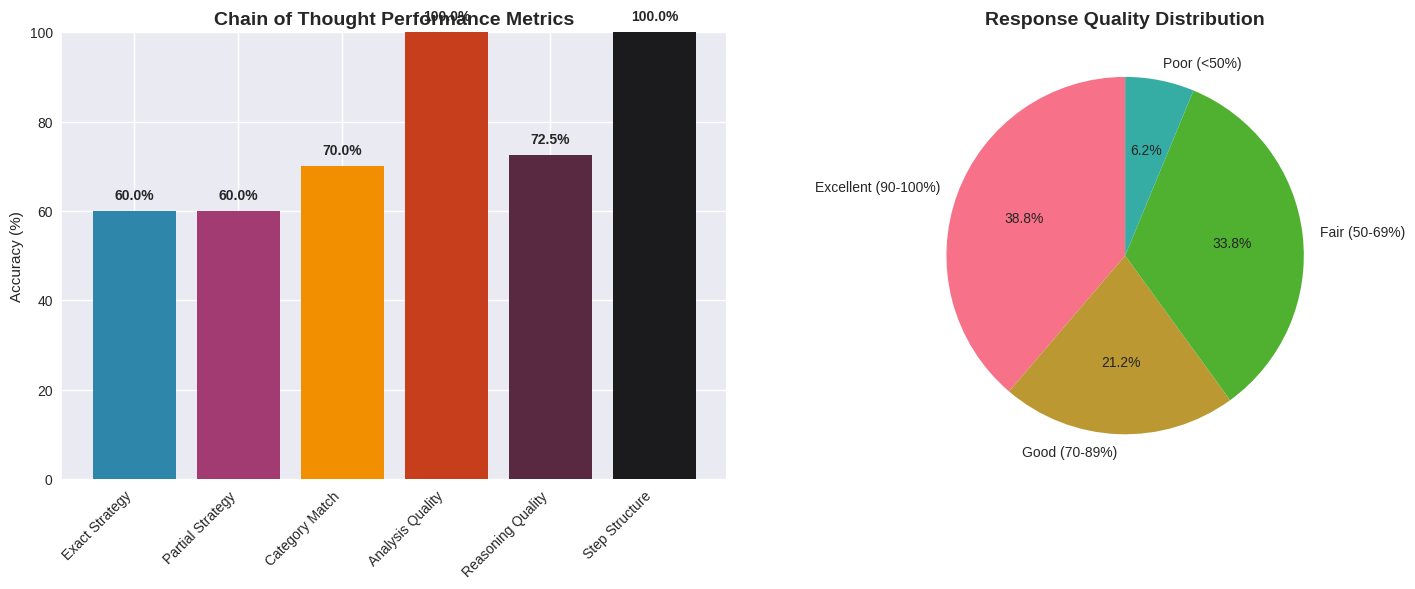


FINAL PERFORMANCE REPORT
Model: scb10x/llama3.2-typhoon2-t1-3b-research-preview
Training Configuration:
  • Epochs: 10
  • Batch Size: 1
  • Learning Rate: 2e-05
  • Max Sequence Length: 512
  • Training Samples: 1071
  • Validation Samples: 189
  • Test Samples: 80

Performance Summary:
  • Exact Strategy Accuracy: 60.0%
  • Category Accuracy: 70.0%
  • Chain of Thought Quality: 100.0%
  • Analysis Presence: 100.0%
  • Reasoning Presence: 72.5%

Overall Model Score: 80.5%
Model Grade: B


In [27]:
# เพิ่ม Cell ใหม่หหลัง Cell 8
import matplotlib.pyplot as plt

def create_performance_dashboard(results, detailed_results):
    """สร้าง dashboard แสดงผลการประเมิน"""

    # Create performance summary
    metrics = {
        'Exact Strategy': results['exact_strategy_accuracy'],
        'Partial Strategy': results['partial_strategy_accuracy'],
        'Category Match': results['category_accuracy'],
        'Analysis Quality': results['analysis_presence'],
        'Reasoning Quality': results['reasoning_presence'],
        'Step Structure': results['step_structure']
    }

    # Plot performance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Main metrics
    ax1.bar(metrics.keys(), metrics.values(), color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592941', '#1B1B1E'])
    ax1.set_title('Chain of Thought Performance Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(0, 100)
    for i, v in enumerate(metrics.values()):
        ax1.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Quality distribution
    quality_categories = ['Excellent (90-100%)', 'Good (70-89%)', 'Fair (50-69%)', 'Poor (<50%)']
    quality_counts = [0, 0, 0, 0]

    for result in detailed_results:
        score = sum(result['scores'].values()) / len(result['scores']) * 100
        if score >= 90:
            quality_counts[0] += 1
        elif score >= 70:
            quality_counts[1] += 1
        elif score >= 50:
            quality_counts[2] += 1
        else:
            quality_counts[3] += 1

    ax2.pie(quality_counts, labels=quality_categories, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Response Quality Distribution', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/performance_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Final report
    print("\n" + "="*80)
    print("FINAL PERFORMANCE REPORT")
    print("="*80)
    print(f"Model: {MODEL_NAME}")
    print(f"Training Configuration:")
    print(f"  • Epochs: {EPOCHS}")
    print(f"  • Batch Size: {BATCH_SIZE}")
    print(f"  • Learning Rate: {LR}")
    print(f"  • Max Sequence Length: {MAX_SEQ_LENGTH}")
    print(f"  • Training Samples: {len(train_dataset)}")
    print(f"  • Validation Samples: {len(val_dataset)}")
    print(f"  • Test Samples: {results['total_samples']}")

    print(f"\nPerformance Summary:")
    print(f"  • Exact Strategy Accuracy: {results['exact_strategy_accuracy']:.1f}%")
    print(f"  • Category Accuracy: {results['category_accuracy']:.1f}%")
    print(f"  • Chain of Thought Quality: {results['step_structure']:.1f}%")
    print(f"  • Analysis Presence: {results['analysis_presence']:.1f}%")
    print(f"  • Reasoning Presence: {results['reasoning_presence']:.1f}%")

    # Overall score
    overall_score = (results['exact_strategy_accuracy'] + results['category_accuracy'] +
                    results['step_structure'] + results['analysis_presence'] +
                    results['reasoning_presence']) / 5

    print(f"\nOverall Model Score: {overall_score:.1f}%")

    grade = "A" if overall_score >= 90 else "B" if overall_score >= 80 else "C" if overall_score >= 70 else "D"
    print(f"Model Grade: {grade}")


    print("="*80)

    return overall_score

# Run dashboard
if 'results' in locals() and 'detailed_results' in locals():
  overall_score = create_performance_dashboard(results, detailed_results)

In [18]:
# Cell 9: Save Model as GGUF Q4_K_M
print("Saving model as GGUF Q4_K_M format...")

# Save as GGUF with Q4_K_M quantization
model.save_pretrained_gguf(
    "/content/drive/MyDrive/AlphaZero_Backups/model_gguf2",  # Full path
    tokenizer,
    quantization_method="q4_k_m"  # Q4_K_M quantization
)

print("Model saved successfully as GGUF Q4_K_M format!")
print("Files saved in: 36_stratagems_model_gguf/")

Saving model as GGUF Q4_K_M format...


Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 6.4G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.21 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:01<00:00, 17.52it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving /content/drive/MyDrive/AlphaZero_Backups/model_gguf2/pytorch_model-00001-of-00002.bin...
Unsloth: Saving /content/drive/MyDrive/AlphaZero_Backups/model_gguf2/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at /content/drive/MyDrive/AlphaZero_Backups/model_gguf2 into f16 GGUF format.
The output location will be /content/drive/MyDrive/AlphaZero_Backups/model_gguf2/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: model_gguf2
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gg

In [17]:
# ดูข้อมูลที่ถูก log ไว้ เช่น training loss, eval loss, step
for log in trainer.state.log_history:
    print(log)


{'loss': 2.3407, 'grad_norm': 1.1191531419754028, 'learning_rate': 0.0, 'epoch': 0.003734827264239029, 'step': 1}
{'loss': 2.4272, 'grad_norm': 1.1989439725875854, 'learning_rate': 9.600000000000001e-06, 'epoch': 0.09337068160597572, 'step': 25}
{'loss': 2.056, 'grad_norm': 1.6443493366241455, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.18674136321195145, 'step': 50}
{'eval_loss': 1.663580298423767, 'eval_runtime': 41.4686, 'eval_samples_per_second': 4.558, 'eval_steps_per_second': 4.558, 'epoch': 0.18674136321195145, 'step': 50}
{'loss': 1.4041, 'grad_norm': 1.2113442420959473, 'learning_rate': 1.999589085949967e-05, 'epoch': 0.2801120448179272, 'step': 75}
{'loss': 1.1519, 'grad_norm': 2.1096434593200684, 'learning_rate': 1.9982875164035103e-05, 'epoch': 0.3734827264239029, 'step': 100}
{'eval_loss': 1.0543569326400757, 'eval_runtime': 40.9667, 'eval_samples_per_second': 4.614, 'eval_steps_per_second': 4.614, 'epoch': 0.3734827264239029, 'step': 100}
{'loss': 1.0212, 'grad_no

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [20]:
def analyze_training_logs(log_history):
    """
    วิเคราะห์และสร้างกราฟจาก training logs
    """
    train_logs = []
    eval_logs = []

    for log in log_history:
        if 'loss' in log and 'eval_loss' not in log:
            train_logs.append(log)
        elif 'eval_loss' in log:
            eval_logs.append(log)

    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    print("="*60)
    print("TRAINING ANALYSIS SUMMARY")
    print("="*60)

    print(f"Total Training Steps: {len(train_df)}")
    print(f"Total Evaluations: {len(eval_df)}")
    print(f"Final Epoch: {train_df['epoch'].iloc[-1]:.2f}" if len(train_df) > 0 else "No training data")

    if len(train_df) > 0:
        print(f"Initial Training Loss: {train_df['loss'].iloc[0]:.4f}")
        print(f"Final Training Loss: {train_df['loss'].iloc[-1]:.4f}")
        print(f"Training Loss Reduction: {train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]:.4f}")
        print(f"Loss Improvement: {((train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]) / train_df['loss'].iloc[0] * 100):.1f}%")

    if len(eval_df) > 0:
        print(f"Initial Eval Loss: {eval_df['eval_loss'].iloc[0]:.4f}")
        print(f"Final Eval Loss: {eval_df['eval_loss'].iloc[-1]:.4f}")
        print(f"Eval Loss Reduction: {eval_df['eval_loss'].iloc[0] - eval_df['eval_loss'].iloc[-1]:.4f}")
        print(f"Best Eval Loss: {eval_df['eval_loss'].min():.4f}")

    if 'learning_rate' in train_df.columns:
        print(f"Max Learning Rate: {train_df['learning_rate'].max():.2e}")
        print(f"Min Learning Rate: {train_df['learning_rate'].min():.2e}")
        print(f"Final Learning Rate: {train_df['learning_rate'].iloc[-1]:.2e}")

    if 'grad_norm' in train_df.columns:
        print(f"Average Gradient Norm: {train_df['grad_norm'].mean():.4f}")
        print(f"Max Gradient Norm: {train_df['grad_norm'].max():.4f}")
        print(f"Gradient Norm Std: {train_df['grad_norm'].std():.4f}")

    print("="*60)

    create_training_plots(train_df, eval_df)

    return train_df, eval_df

In [21]:
def create_training_plots(train_df, eval_df):
    # 1. Loss Curves
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0:
        plt.plot(train_df['step'], train_df['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    if len(eval_df) > 0:
        plt.plot(eval_df['step'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss Curves', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 2. Learning Rate Schedule
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0 and 'learning_rate' in train_df.columns:
        plt.plot(train_df['step'], train_df['learning_rate'], 'g-', linewidth=2, marker='o', markersize=3)
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        plt.grid(True, alpha=0.3)
    plt.savefig('learning_rate.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 3. Gradient Norm
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0 and 'grad_norm' in train_df.columns:
        plt.plot(train_df['step'], train_df['grad_norm'], 'purple', linewidth=2, marker='o', markersize=3)
        plt.xlabel('Training Steps')
        plt.ylabel('Gradient Norm')
        plt.title('Gradient Norm', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Clipping Threshold')
        plt.legend()
    plt.savefig('gradient_norm.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 4. Loss by Epoch
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0:
        plt.plot(train_df['epoch'], train_df['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    if len(eval_df) > 0:
        plt.plot(eval_df['epoch'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss by Epoch', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('loss_by_epoch.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 5. Loss Smoothing
    plt.figure(figsize=(10, 6))
    if len(train_df) > 5:
        window_size = max(1, len(train_df) // 10)
        train_df_copy = train_df.copy()
        train_df_copy['loss_smooth'] = train_df_copy['loss'].rolling(window=window_size, center=True).mean()
        plt.plot(train_df_copy['step'], train_df_copy['loss'], alpha=0.3, color='lightblue', label='Raw Loss')
        plt.plot(train_df_copy['step'], train_df_copy['loss_smooth'], 'darkblue', linewidth=3, label='Smoothed Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Loss Smoothing', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    plt.savefig('loss_smoothing.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 6. Evaluation Performance
    plt.figure(figsize=(10, 6))
    if len(eval_df) > 0:
        metrics = ['eval_samples_per_second', 'eval_runtime']
        colors = ['orange', 'brown']
        for i, metric in enumerate(metrics):
            if metric in eval_df.columns:
                ax = plt.gca() if i == 0 else plt.gca().twinx()
                ax.plot(eval_df['step'], eval_df[metric], color=colors[i],
                       linewidth=2, marker='o', markersize=4, label=metric.replace('_', ' ').title())
                ax.set_ylabel(metric.replace('_', ' ').title(), color=colors[i])
                ax.tick_params(axis='y', labelcolor=colors[i])
        plt.xlabel('Training Steps')
        plt.title('Evaluation Performance', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
    plt.savefig('evaluation_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [22]:
def create_detailed_summary_table(train_df, eval_df):
    print("\n" + "="*80)
    print("DETAILED TRAINING METRICS")
    print("="*80)

    if len(train_df) > 0:
        print("\nTRAINING METRICS:")
        print("-" * 40)
        summary_data = {
            'Metric': ['Initial Loss', 'Final Loss', 'Best Loss', 'Loss Reduction', 'Avg Gradient Norm', 'Max Gradient Norm'],
            'Value': [
                f"{train_df['loss'].iloc[0]:.4f}",
                f"{train_df['loss'].iloc[-1]:.4f}",
                f"{train_df['loss'].min():.4f}",
                f"{train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]:.4f}",
                f"{train_df['grad_norm'].mean():.4f}" if 'grad_norm' in train_df.columns else 'N/A',
                f"{train_df['grad_norm'].max():.4f}" if 'grad_norm' in train_df.columns else 'N/A'
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

    if len(eval_df) > 0:
        print("\nEVALUATION METRICS:")
        print("-" * 40)
        eval_summary = {
            'Metric': ['Initial Eval Loss', 'Final Eval Loss', 'Best Eval Loss', 'Eval Loss Reduction', 'Avg Eval Time', 'Avg Samples/Sec'],
            'Value': [
                f"{eval_df['eval_loss'].iloc[0]:.4f}",
                f"{eval_df['eval_loss'].iloc[-1]:.4f}",
                f"{eval_df['eval_loss'].min():.4f}",
                f"{eval_df['eval_loss'].iloc[0] - eval_df['eval_loss'].iloc[-1]:.4f}",
                f"{eval_df['eval_runtime'].mean():.2f}s" if 'eval_runtime' in eval_df.columns else 'N/A',
                f"{eval_df['eval_samples_per_second'].mean():.2f}" if 'eval_samples_per_second' in eval_df.columns else 'N/A'
            ]
        }
        eval_summary_df = pd.DataFrame(eval_summary)
        print(eval_summary_df.to_string(index=False))

    if len(train_df) > 1:
        print("\nTRAINING EFFICIENCY:")
        print("-" * 40)
        total_steps = train_df['step'].iloc[-1]
        total_epochs = train_df['epoch'].iloc[-1]
        loss_per_step = (train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]) / total_steps
        efficiency_data = {
            'Metric': ['Total Steps', 'Total Epochs', 'Loss Reduction per Step', 'Steps per Epoch'],
            'Value': [
                f"{total_steps}",
                f"{total_epochs:.2f}",
                f"{loss_per_step:.6f}",
                f"{total_steps/total_epochs:.1f}" if total_epochs > 0 else 'N/A'
            ]
        }
        efficiency_df = pd.DataFrame(efficiency_data)
        print(efficiency_df.to_string(index=False))

In [23]:
def analyze_your_training_logs(trainer):
    """
    ใช้ฟังก์ชันนี้กับ trainer ของคุณ
    """
    log_history = trainer.state.log_history

    train_df, eval_df = analyze_training_logs(log_history)
    create_detailed_summary_table(train_df, eval_df)

    if len(train_df) > 0:
        train_df.to_csv('training_logs.csv', index=False)
        print(f"\nTraining data saved to: training_logs.csv")
    if len(eval_df) > 0:
        eval_df.to_csv('evaluation_logs.csv', index=False)
        print(f"Evaluation data saved to: evaluation_logs.csv")

    return train_df, eval_df

TRAINING ANALYSIS SUMMARY
Total Training Steps: 59
Total Evaluations: 29
Final Epoch: 5.41
Initial Training Loss: 2.3407
Final Training Loss: 0.0852
Training Loss Reduction: 2.2555
Loss Improvement: 96.4%
Initial Eval Loss: 1.6636
Final Eval Loss: 0.1258
Eval Loss Reduction: 1.5378
Best Eval Loss: 0.1228
Max Learning Rate: 2.00e-05
Min Learning Rate: 0.00e+00
Final Learning Rate: 9.00e-06
Average Gradient Norm: 2.0876
Max Gradient Norm: 5.0161
Gradient Norm Std: 0.7889


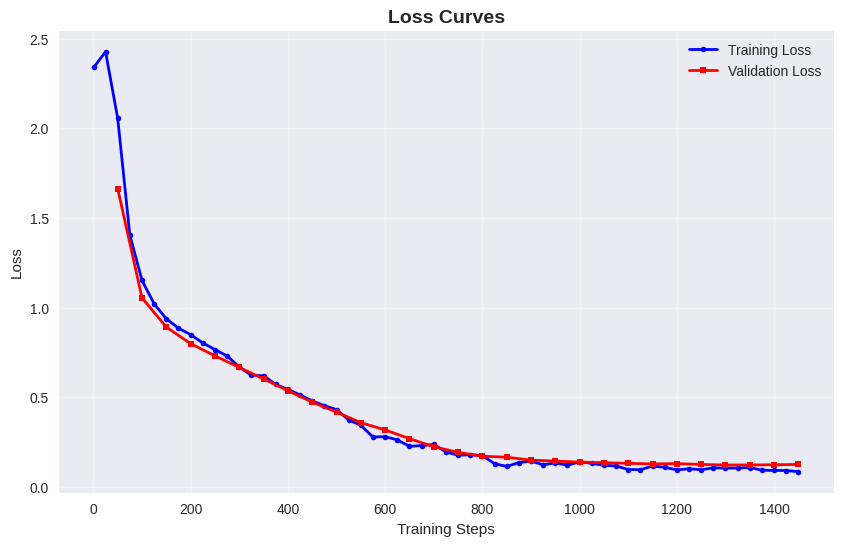

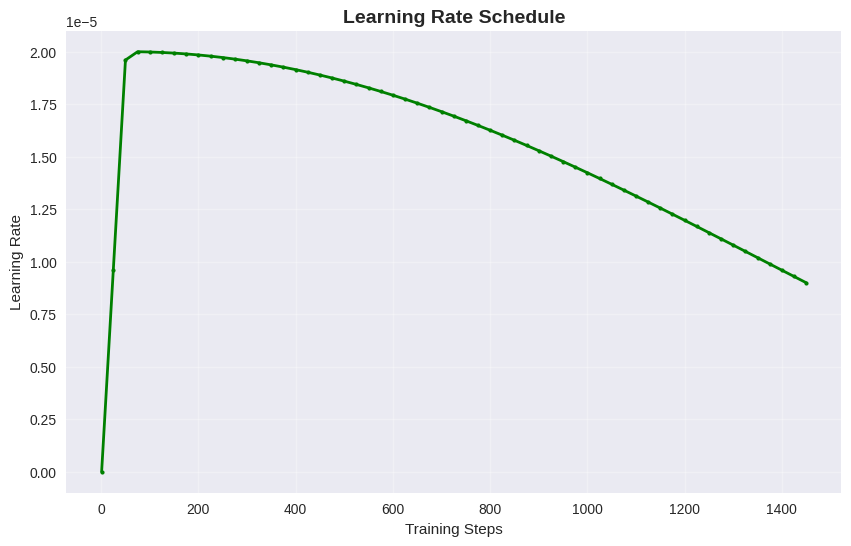

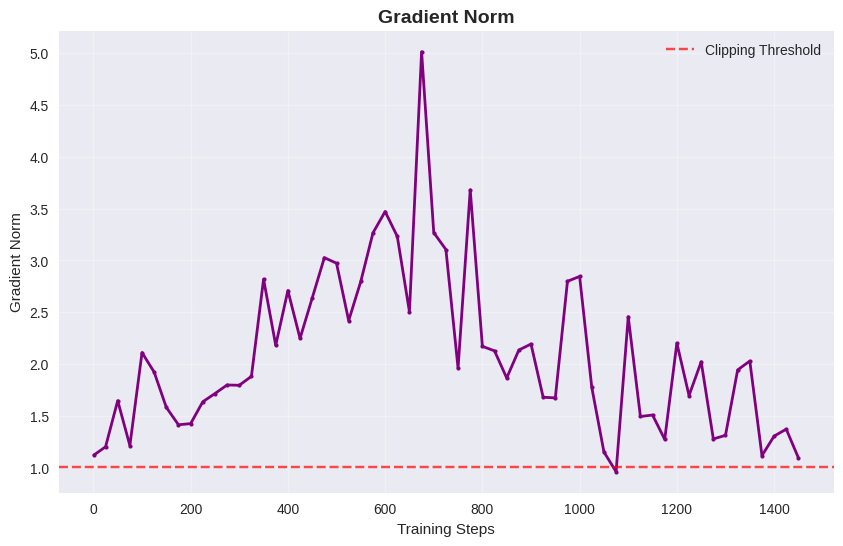

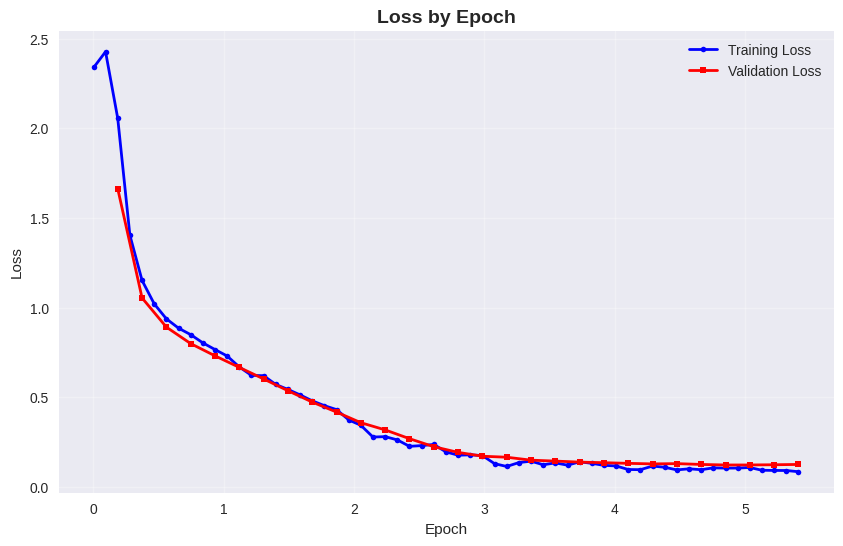

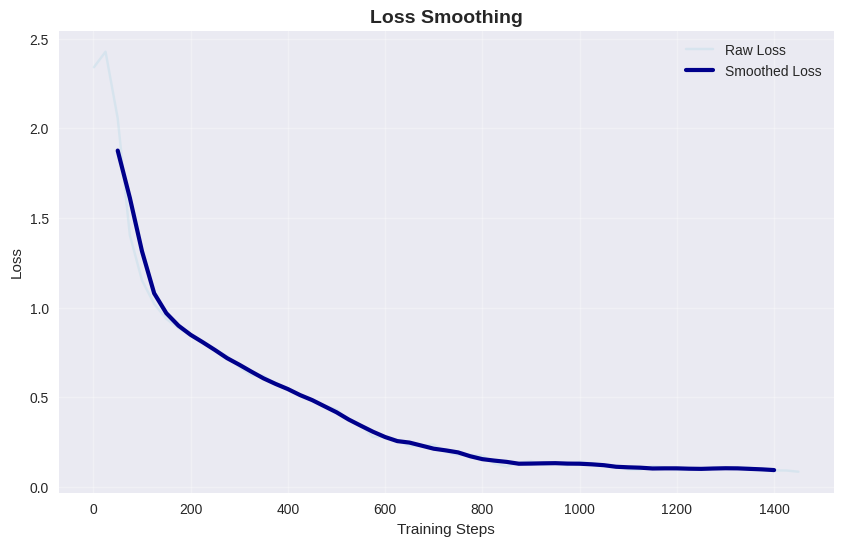

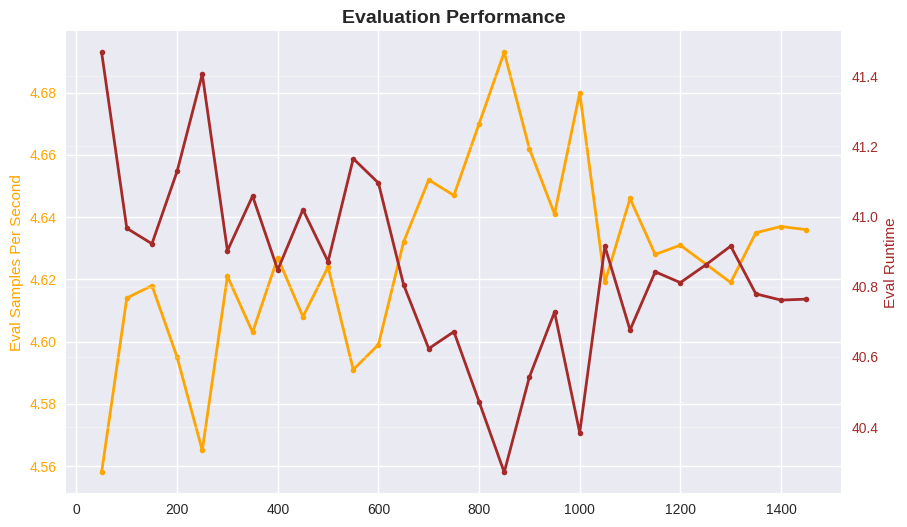


DETAILED TRAINING METRICS

TRAINING METRICS:
----------------------------------------
           Metric  Value
     Initial Loss 2.3407
       Final Loss 0.0852
        Best Loss 0.0852
   Loss Reduction 2.2555
Avg Gradient Norm 2.0876
Max Gradient Norm 5.0161

EVALUATION METRICS:
----------------------------------------
             Metric  Value
  Initial Eval Loss 1.6636
    Final Eval Loss 0.1258
     Best Eval Loss 0.1228
Eval Loss Reduction 1.5378
      Avg Eval Time 40.85s
    Avg Samples/Sec   4.63

TRAINING EFFICIENCY:
----------------------------------------
                 Metric    Value
            Total Steps     1450
           Total Epochs     5.41
Loss Reduction per Step 0.001556
        Steps per Epoch    268.0

Training data saved to: training_logs.csv
Evaluation data saved to: evaluation_logs.csv


In [24]:
train_df, eval_df = analyze_your_training_logs(trainer)